In [770]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re 
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Bidirectional, Dense, Activation, Dropout, Embedding
from keras.callbacks import EarlyStopping
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to C:\Users\Benny
[nltk_data]     Ho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Project

In this competition, you have to predict the genre of a song given a segment of lyrics.

The two genres are pop(1) and rap(0).

Lyrics were scraped from Genius.com. We have censored several words by replacing letters with asterisks. Please note that some lyrics were taken from explicit songs.
Genre was determined based on Billboard Charts.

You can use deep learning and NLP libraries for this competition.

link: https://www.kaggle.com/c/rnn-competition-2020-2021/leaderboard

## Load data

In [772]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [773]:
train_df.head(5)

,lyric,class
0,Can't drink without thinkin' about you,1
1,Now Lil Pump flyin' private jet (Yuh),0
2,"No, matter fact, you ain't help me when I had ...",0
3,"And you could find me, I ain't hidin'",0
4,From the way you talk to the way you move,1


In [774]:
test_df.head(5)

,id,lyric
0,0,Now they know my name wherever I go
1,1,"If your girl don't get it poppin', put me on y..."
2,2,"P1 cleaner than your church shoes, ah"
3,3,"Bodies start to drop, ayy (Hit the floor)"
4,4,I don't look to the sky no mo'


## Exploratory data analysis

In [775]:
# check dimension
print(train_df.shape)
print(test_df.shape)

(51054, 2)
(2676, 2)


The train dataset has 51054 rows and 2 columns while the test set has 2676 rows and 2 columns. 

### Data type for each attribute

In [776]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51054 entries, 0 to 51053
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyric   51054 non-null  object
 1   class   51054 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 797.8+ KB


In [777]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676 entries, 0 to 2675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2676 non-null   int64 
 1   lyric   2676 non-null   object
dtypes: int64(1), object(1)
memory usage: 41.9+ KB


- The attributes of the train set consists of 1 integer and 1 object data type
- The attributes of the test set consists of 1 integer and 1 object data type

### Descriptive statistics

In [778]:
train_df.describe()

,class
count,51054.000000
mean,0.434227
std,0.495660
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [779]:
test_df.describe()

,id
count,2676.000000
mean,1337.500000
std,772.638984
min,0.000000
25%,668.750000
50%,1337.500000
75%,2006.250000
max,2675.000000


In [780]:
# check the distribution of the class variable
train_df['class'].value_counts()

0    28885
1    22169
Name: class, dtype: int64

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Disribution of target variable')

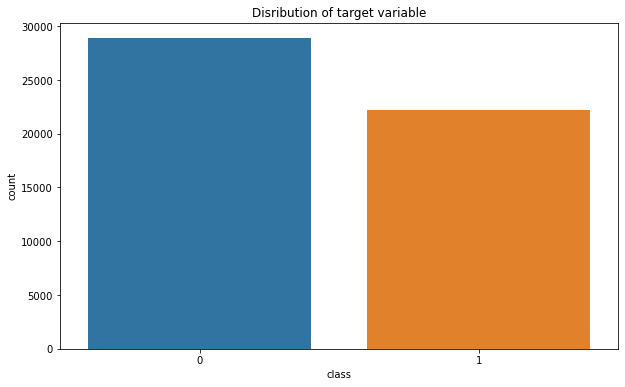

In [781]:
plt.figure(figsize=(10,6))
sns.countplot('class', data=train_df).set_title('Disribution of target variable')

The class variable has imbalanced class distribution. Class with value 1 (pop) is less than class with value 0 (rap), which means there are more genres of rap than genres of pop. For overcoming this problem, we can upsample or downsample the dataset.

## Data Preparation

### Data cleaning

In [782]:
# check for missing values
train_df.isnull().sum()

lyric    0
class    0
dtype: int64

In [783]:
test_df.isnull().sum()

id       0
lyric    0
dtype: int64

There are no missing values in both datasets.

In [784]:
train_df.head(5)

,lyric,class
0,Can't drink without thinkin' about you,1
1,Now Lil Pump flyin' private jet (Yuh),0
2,"No, matter fact, you ain't help me when I had ...",0
3,"And you could find me, I ain't hidin'",0
4,From the way you talk to the way you move,1


In [785]:
test_df.head(5)

,id,lyric
0,0,Now they know my name wherever I go
1,1,"If your girl don't get it poppin', put me on y..."
2,2,"P1 cleaner than your church shoes, ah"
3,3,"Bodies start to drop, ayy (Hit the floor)"
4,4,I don't look to the sky no mo'


The id column seems to be irrelevant. Therefore the column will be removed.

In [786]:
test_df = test_df.drop(['id'], axis=1)

In [787]:
train_df.head(5)

,lyric,class
0,Can't drink without thinkin' about you,1
1,Now Lil Pump flyin' private jet (Yuh),0
2,"No, matter fact, you ain't help me when I had ...",0
3,"And you could find me, I ain't hidin'",0
4,From the way you talk to the way you move,1


In [788]:
test_df.head(5)

,lyric
0,Now they know my name wherever I go
1,"If your girl don't get it poppin', put me on y..."
2,"P1 cleaner than your church shoes, ah"
3,"Bodies start to drop, ayy (Hit the floor)"
4,I don't look to the sky no mo'


## Data preprocessing

### Clean data

In [789]:
def clean(sentence):
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(sentence))
    
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    return text_lower

In [790]:
train_df['lyric'] = train_df['lyric'].apply(lambda x: clean(x))
train_df

,lyric,class
0,can't drink without thinkin' about you,1
1,now lil pump flyin' private jet yuh,0
2,no matter fact you ain't help me when i had ...,0
3,and you could find me i ain't hidin',0
4,from the way you talk to the way you move,1
...,...,...
51049,i told her pour me some more then she went ri...,0
51050,hit the ground and crawl to the dresser,0
51051,just keep breathin' and breathin' and breathin...,1
51052,down go the system long live the king king,0


In [791]:
test_df['lyric'] = test_df['lyric'].apply(lambda x: clean(x))
test_df

,lyric
0,now they know my name wherever i go
1,if your girl don't get it poppin' put me on y...
2,p cleaner than your church shoes ah
3,bodies start to drop ayy hit the floor
4,i don't look to the sky no mo'
...,...
2671,so tell me how deep is your love
2672,if this is all we're living for
2673,i'll never let up on the pedal might as well ...
2674,turned my temple down into a prison s


### Removing stop words

In [792]:
def removing_stop_words(sentence):
    
    stop_words = set(stopwords.words('english'))
    
    # tokenize
    word_tokens = word_tokenize(sentence)
    
    filtered_sentence = [w for w in word_tokens  if not w in stop_words]
    
    filtered_sentence = []
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    return filtered_sentence

In [793]:
train_df['lyric'] = train_df['lyric'].apply(lambda x: removing_stop_words(x))
train_df['lyric']

0                    [ca, n't, drink, without, thinkin, ']
1                 [lil, pump, flyin, ', private, jet, yuh]
2                     [matter, fact, ai, n't, help, money]
3                         [could, find, ai, n't, hidin, ']
4                                   [way, talk, way, move]
                               ...                        
51049                [told, pour, went, right, blow, blow]
51050                        [hit, ground, crawl, dresser]
51051    [keep, breathin, ', breathin, ', breathin, ', ...
51052                 [go, system, long, live, king, king]
51053                           [mother, knew, things, oh]
Name: lyric, Length: 51054, dtype: object

In [794]:
test_df['lyric'] = test_df['lyric'].apply(lambda x: removing_stop_words(x))
test_df

,lyric
0,"[know, name, wherever, go]"
1,"[girl, n't, get, poppin, ', put, wishlist]"
2,"[p, cleaner, church, shoes, ah]"
3,"[bodies, start, drop, ayy, hit, floor]"
4,"[n't, look, sky, mo, ']"
...,...
2671,"[tell, deep, love]"
2672,"['re, living]"
2673,"['ll, never, let, pedal, might, well, get, mop]"
2674,"[turned, temple, prison]"


### Stemming

In [795]:
stemmer = PorterStemmer()
train_df['lyric'] = train_df['lyric'].apply(lambda x: " ".join(stemmer.stem(token) for token in x))
train_df

,lyric,class
0,ca n't drink without thinkin ',1
1,lil pump flyin ' privat jet yuh,0
2,matter fact ai n't help money,0
3,could find ai n't hidin ',0
4,way talk way move,1
...,...,...
51049,told pour went right blow blow,0
51050,hit ground crawl dresser,0
51051,keep breathin ' breathin ' breathin ' breathin ',1
51052,go system long live king king,0


In [796]:
test_df['lyric'] = test_df['lyric'].apply(lambda x: " ".join(stemmer.stem(token) for token in x))
test_df

,lyric
0,know name wherev go
1,girl n't get poppin ' put wishlist
2,p cleaner church shoe ah
3,bodi start drop ayi hit floor
4,n't look sky mo '
...,...
2671,tell deep love
2672,'re live
2673,'ll never let pedal might well get mop
2674,turn templ prison


### Splitting the data

In [797]:
X = train_df['lyric']
y = train_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [798]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35737,)
(15317,)
(35737,)
(15317,)


In [799]:
#from sklearn.utils import resample

# combine them back for resampling
train_df = pd.concat([X_train, y_train], axis=1)
train_df['class'].value_counts()

# seperate majority and minority classes
df_majority = train_df[train_df['class'] == 0]
df_minority = train_df[train_df['class'] != 0]

# downsample majority
df_majority_downsampled = resample(df_majority, replace=False, n_samples=15497, random_state=42)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['class'].value_counts()

0    15497
1    15497
Name: class, dtype: int64

In [800]:
X_train = df_downsampled['lyric']
y_train = df_downsampled['class']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30994,)
(30994,)
(15317,)
(15317,)


In [801]:
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

## Feature Extraction

### Bag of words

In [802]:
# Omzetten naar bag-of-words

count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit_transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)


tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)

## Model training

#### Machine learning

##### Logistic Regression

In [803]:
lregclassifier = LogisticRegression(C=10)

lregclassifier.fit(X_train_tf, y_train)

y_pred = lregclassifier.predict(X_test_tf)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

           0       0.84      0.74      0.78      8645
           1       0.70      0.81      0.75      6672

    accuracy                           0.77     15317
   macro avg       0.77      0.77      0.77     15317
weighted avg       0.78      0.77      0.77     15317

[[6367 2278]
 [1256 5416]]
76.92759678788275


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [804]:
print("score on train: "+ str(lregclassifier.score(X_train_tf, y_train) * 100))
print("score on test: " + str(lregclassifier.score(X_test_tf, y_test) * 100))

score on train: 84.9745111957153
score on test: 76.92759678788275


In [805]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
paramaters = [
             {'C' : [0.25, 0.5, 0.75, 1, 10, 50, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'], 
              'class_weight': [None, 'balanced']},
             ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )



Fitting 4 folds for each of 70 candidates, totalling 280 fits
Best accuracy :  0.7646316529726254
Best parameters : {'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [806]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

parameters = [
             {'C' : [0.25, 0.5, 0.75, 1, 10, 50, 100], 
              'solver': ['liblinear','lbfgs', 'newton-cg', 'sag','saga'],
              'class_weight': [None, 'balanced']}
             ]

              

n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=4,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )



Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best accuracy :  0.7646316529726254
Best parameters : {'solver': 'lbfgs', 'class_weight': 'balanced', 'C': 10}


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


As you can see, I've used the logistic regression algorithm for the machine learning model. The best accuracy amounts 76.92%, now I'll try using the RNN algorithm for deep learning to see whether it is more suitable for this case.

#### Deep learning

##### Preprocessing the text data

In [727]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_fatures = 2000

tokenizer = Tokenizer(oov_token= True, num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train_clean)
X_train_tok = tokenizer.texts_to_sequences(X_train_clean)
X_test_tok = tokenizer.texts_to_sequences(X_test_clean)

X_train_tok = pad_sequences(X_train_tok)
X_test_tok = pad_sequences(X_test_tok,maxlen=X_train_tok.shape[1])

##### one-hot-encoding

In [728]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_train_class = to_categorical(y_train)

y_test = encoder.transform(y_test)
y_test_class = to_categorical(y_test)

#####  Model

In [747]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

from keras.callbacks import EarlyStopping

early_stopping =  EarlyStopping(patience=3,  restore_best_weights=True)

model = Sequential()
model.add(Embedding(input_dim=2000,output_dim =128, input_length = X_train_tok.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

history = model.fit(X_train_tok, y_train_class, epochs = 100, batch_size=8, verbose = 2, validation_data=(X_test_tok,y_test_class),
                   callbacks=[early_stopping])

Epoch 1/100
3875/3875 - 150s - loss: 0.5094 - accuracy: 0.7576 - val_loss: 0.4669 - val_accuracy: 0.7829
Epoch 2/100
3875/3875 - 146s - loss: 0.4364 - accuracy: 0.8030 - val_loss: 0.4519 - val_accuracy: 0.7951
Epoch 3/100
3875/3875 - 147s - loss: 0.4026 - accuracy: 0.8202 - val_loss: 0.4584 - val_accuracy: 0.7951
Epoch 4/100
3875/3875 - 145s - loss: 0.3757 - accuracy: 0.8313 - val_loss: 0.4510 - val_accuracy: 0.8001
Epoch 5/100
3875/3875 - 151s - loss: 0.3483 - accuracy: 0.8437 - val_loss: 0.4437 - val_accuracy: 0.8082
Epoch 6/100
3875/3875 - 149s - loss: 0.3195 - accuracy: 0.8602 - val_loss: 0.6069 - val_accuracy: 0.8101
Epoch 7/100
3875/3875 - 148s - loss: 0.2915 - accuracy: 0.8725 - val_loss: 0.5166 - val_accuracy: 0.8092
Epoch 8/100
3875/3875 - 144s - loss: 0.2676 - accuracy: 0.8827 - val_loss: 0.5482 - val_accuracy: 0.8071


In [748]:
# save model
# model.save('model.h5', history)

In [749]:
from keras.models import load_model
model = load_model('model.h5')

### Accuracy

In [750]:
accuracy = model.evaluate(X_test_tok, y_test_class)

479/479 [==============================] - 7s 15ms/step - loss: 0.4437 - accuracy: 0.8082


The RNN model has an accuracy of 80.82% which is slightly better than the ML model with 76.92%. Therefore, the evaluation will be based on the DL model.

## Evaluating the model

### Plotting out training history

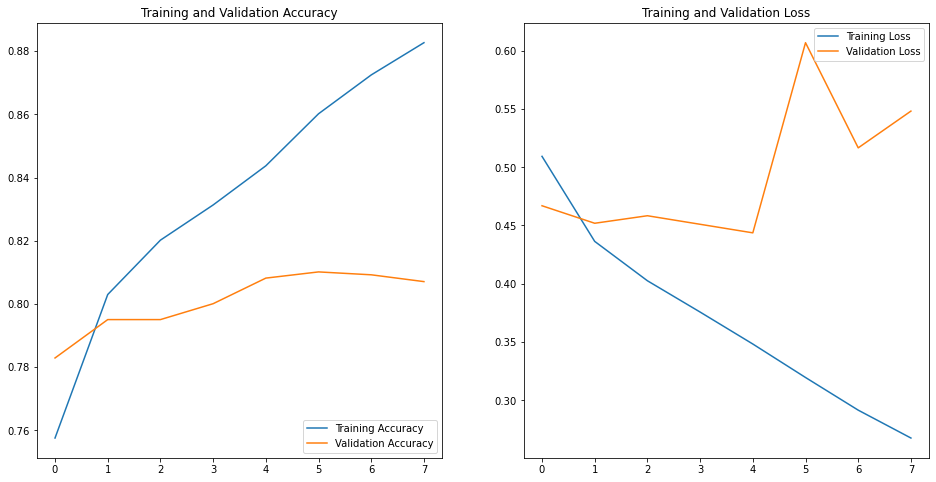

In [751]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

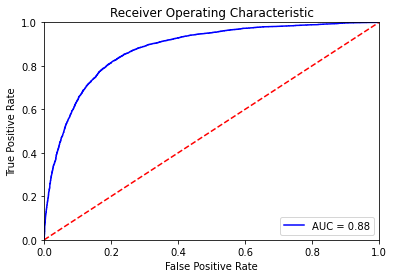

In [752]:
# Area under ROC curve

import sklearn.metrics as metrics

probs = model.predict(X_test_tok)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
 

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

You can see the AUC amounts 0.88 which is relatively close to 1 and greater than 0.5, suggesting some skill in the predictions.

### Evaluating on given test set

In [753]:
pred_results = []
for i in model.predict(X_test_tok[:10]):
    pred_results.append(np.argmax(i))
    
print(pred_results)

[0, 1, 0, 1, 1, 1, 0, 0, 1, 0]


In [754]:
actual_results = []
for i in y_test_class[:10]:
    actual_results.append(np.argmax(i))
print(actual_results)

[0, 0, 0, 1, 1, 1, 0, 1, 0, 0]


In [755]:
answer = []
answer_incorrect = []

zip_object = zip(pred_results, actual_results)

for x, y in zip_object:
    if x == y:
        answer.append(x)
    else:
        answer_incorrect.append(x)

In [756]:
print("Predicted answers are : ", answer)
print("Unpredicted answers are : ", answer_incorrect)

Predicted answers are :  [0, 0, 1, 1, 1, 0, 0]
Unpredicted answers are :  [1, 0, 1]


### Prediction

In [757]:
sample_sub=pd.read_csv('sample.csv')


In [758]:
X_test = test_df['lyric']
X_test

0                          know name wherev go
1           girl n't get poppin ' put wishlist
2                     p cleaner church shoe ah
3                bodi start drop ayi hit floor
4                            n't look sky mo '
                         ...                  
2671                            tell deep love
2672                                  're live
2673    'll never let pedal might well get mop
2674                         turn templ prison
2675                      yeah 's fact never p
Name: lyric, Length: 2676, dtype: object

In [759]:
X_test_tok = tokenizer.texts_to_sequences(X_test)

X_test_tok = pad_sequences(X_test_tok,maxlen=X_train_tok.shape[1])

In [760]:
X_test_tok

array([[   0,    0,    0, ...,  135, 1114,   12],
       [   0,    0,    0, ...,    2,   52,    1],
       [   0,    0,    0, ...,    1,  721,  107],
       ...,
       [   0,    0,    0, ...,  169,   11, 1375],
       [   0,    0,    0, ...,   88,    1,    1],
       [   0,    0,    0, ...,  486,   33,  150]])

In [761]:
y_pre = model.predict(X_test_tok)
classes = np.argmax(y_pre, axis=1)



In [762]:
submission_df = pd.DataFrame()

In [763]:
submission_df['id'] = sample_sub['id']
submission_df['class'] = classes
submission_df

,id,class
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
2671,2671,1
2672,2672,1
2673,2673,0
2674,2674,0


In [764]:
# submission for the competition
submission_df.to_csv('submission_2.csv', index=False)

Here below you can see the result of my submission:

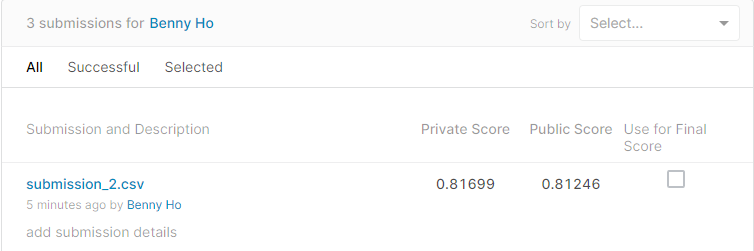